In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

In [ ]:
model_name = "dbmdz/bert-base-italian-cased"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Loading the tokenizer and the model via Huggingface's Transformers library
tokenizer = AutoTokenizer.from_pretrained(model_name)

# We set 'output_hidden_states' equal to 'True' because we want to extract the representations from all the layers of the model
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [ ]:
!git clone https://github.com/michelepapucci/multilevel-text-simplification-italian.git

Cloning into 'multilevel-text-simplification-italian'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 4), reused 12 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 6.32 MiB | 5.93 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
import pandas as pd
from tqdm import tqdm

df = pd.read_csv("/content/multilevel-text-simplification-italian/data/wikipedia_simplifications_profiled .csv")
df

,idx,original_sentence_idx,original_text,simplification,readit_og,readit_simp,n_sentences_og,n_tokens_og,tokens_per_sent_og,char_per_tok_og,...,verb_edges_dist_5_simp,verb_edges_dist_2_simp,verb_edges_dist_0_simp,verb_edges_dist_4_simp,verb_edges_dist_1_simp,avg_verb_edges_simp,highest_class_og,highest_class_simp,average_class_og,average_class_simp
0,343,35,Dalla concessione all'allaccio della conduttur...,Dalla concessione all'attivazione della condut...,0.870711,0.865133,1,62,62.0,4.800000,...,20.0,0.0,0.0,0.0,20.0,3.0,22,17,7.844444,7.711111
1,344,35,Dalla concessione all'allaccio della conduttur...,Dalla concessione all'attivazione della condut...,0.870711,0.866448,1,62,62.0,4.800000,...,20.0,0.0,0.0,0.0,20.0,3.0,22,17,7.844444,7.733333
2,347,35,Dalla concessione all'allaccio della conduttur...,La concessione dell'allaccio della conduttura ...,0.870711,0.565192,1,62,62.0,4.800000,...,0.0,0.0,0.0,0.0,0.0,3.0,22,21,7.844444,8.277778
3,348,35,Dalla concessione all'allaccio della conduttur...,La concessione dell'allaccio della conduttura ...,0.870711,0.579117,1,62,62.0,4.800000,...,0.0,0.0,0.0,0.0,0.0,3.0,22,21,7.844444,8.277778
4,349,35,Dalla concessione all'allaccio della conduttur...,"Gli ornamenti della fontana includono delfini,...",0.870711,0.126862,1,62,62.0,4.800000,...,0.0,100.0,0.0,0.0,0.0,2.0,22,16,7.844444,9.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14288,1070964,108349,La carriera di José Rivera inizia nella squadr...,Il percorso di carriera di José Rivera ha comi...,0.303828,0.256623,1,28,28.0,4.230769,...,0.0,100.0,0.0,0.0,0.0,2.0,14,20,6.739130,6.583333
14289,1070965,108349,La carriera di José Rivera inizia nella squadr...,Il percorso di carriera di José Rivera ha comi...,0.303828,0.293200,1,28,28.0,4.230769,...,0.0,100.0,0.0,0.0,0.0,2.0,14,20,6.739130,6.625000
14290,1070968,108349,La carriera di José Rivera inizia nella squadr...,La carriera di José Rivera iniziò con la squad...,0.303828,0.302930,1,28,28.0,4.230769,...,0.0,100.0,0.0,0.0,0.0,2.0,14,20,6.739130,7.227273
14291,1070969,108349,La carriera di José Rivera inizia nella squadr...,"Nella squadra della sua università, l'Ohio Sta...",0.303828,0.072132,1,28,28.0,4.230769,...,0.0,0.0,0.0,100.0,0.0,4.0,14,20,6.739130,8.187500


In [ ]:
df = df.groupby("original_sentence_idx", sort=False).nth(0).reset_index()

In [ ]:
embeddings = []
ids = []
sentences = []

# Extracting the representations from each sentence of the probing dataset, with model(*input_ids*), where *input_ids* corresponds to the tokenized sentence
for index, line in tqdm(df.iterrows(), total=len(df)):
  sent_id = index
  sentence = line['original_text']

  # Tokenization of the sentence
  input_ids = tokenizer.encode(sentence, add_special_tokens=True)
  input_ids = torch.tensor([input_ids]).to(device)

  # Extraction of the representations
  with torch.no_grad():
    outputs = model(input_ids)
    embeddings.append(outputs["hidden_states"])
    ids.append(sent_id)
    sentences.append(sentence)

100%|██████████| 2000/2000 [00:32<00:00, 61.45it/s]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.dummy import DummyRegressor

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr

In [ ]:
def probing(embeddings, df, ids, feature, layer):

  # Dataset containing only the selected linguistic feature
  df_feature = df[feature]

  X = []
  y = []

  for id, sentence in zip(ids, embeddings):
    embedding_layer = sentence[layer][0]

    # We extract the representation from the [CLS] token, that is the first token in each input sequence, having set 'add_special_tokens' equal to 'True' during tokenization
    cls_embedding = embedding_layer[0].tolist()

    # Access to the value of the linguistic feature 'feature' for the given sentence, based on the id
    feat = df.loc[id, feature]


    X.append(cls_embedding)
    y.append(feat)

  # Diving the dataset into train and test files
  X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, ids, test_size=0.20, random_state=42)

  # Defining the probing model
  probing_model = LinearSVR(dual=False, loss='squared_epsilon_insensitive')

  # Fit the model on the training data and then predict on X_test
  probing_model.fit(X_train, y_train)
  y_pred = probing_model.predict(X_test)

  # Evaluation of the predictions
  corr, p_val = spearmanr(y_test, y_pred)

  # Save the predictions for further analysis
  df_preds = pd.DataFrame(columns=["sent_id",
                                   "y_true",
                                   "y_pred"])
  df_preds["sent_id"] = ids_test
  df_preds["y_true"] = y_test
  df_preds["y_pred"] = y_pred
  df_preds.to_csv(f'/content/results_{layer}_{feature}.tsv',
                  sep='\t', index=True)

  return corr, p_val

In [ ]:
def baseline(df, feature):
  # Select "n_tokens" as X for the baseline probing model
  X = df["n_tokens_og"].to_numpy()
  X = X.reshape(-1, 1)
  y = df[feature].to_numpy()

  # Diving the dataset into train and test files
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

  # Defining the probing model
  probing_model = LinearSVR(dual=False, loss='squared_epsilon_insensitive')

  # Fit the model on the training data and then predict on X_test
  probing_model.fit(X_train, y_train)
  y_pred = probing_model.predict(X_test)

  # Evaluation of the predictions
  corr, p_val = spearmanr(y_test, y_pred)

  return corr, p_val

In [ ]:
selected_features = ["n_tokens_og",
                     "char_per_tok_og",
                     "upos_dist_NOUN_og",
                     "upos_dist_VERB_og",
                     "avg_token_per_clause_og",
                     "avg_subordinate_chain_len_og"
                     ]
n_layers=12
layers = list(range(n_layers)[1:])

# Create an empty pandas DataFrame to store the probing results
results = pd.DataFrame(index=selected_features, columns=layers + ["Baseline"])

# Iterate over the selected features
with tqdm(total=len(selected_features) * len(layers), desc="Probing") as pbar:
  for feature in selected_features:
    # Iterate over the 12 layers of the model
    for layer in layers:
      pbar.update()
      corr, p_val = probing(embeddings, df, ids, feature, layer)

      # Save the score only if the correlation is statistically significant (p-value < 0.05)
      if p_val < 0.05:
        results.loc[feature, layer] = corr

# Simple baseline model trained to predict the selected linguistic feature using only "n_tokens" as input feature
  corr_baseline, p_val_baseline = baseline(df, feature)
  if p_val < 0.05:
    results.loc[feature, "Baseline"] = corr_baseline

Probing: 100%|██████████| 66/66 [00:47<00:00,  1.39it/s]


In [ ]:
  results

,1,2,3,4,5,6,7,8,9,10,11,Baseline
n_tokens_og,0.957086,0.938991,0.940505,0.935696,0.930793,0.928028,0.937493,0.932072,0.922754,0.894867,0.863979,NaN
char_per_tok_og,0.848331,0.832535,0.832315,0.828478,0.814375,0.812684,0.79806,0.787995,0.8045,0.674886,0.6177,NaN
upos_dist_NOUN_og,0.710993,0.674475,0.675128,0.645009,0.66168,0.664676,0.684763,0.67511,0.636463,0.616863,0.537269,NaN
upos_dist_VERB_og,0.67828,0.716642,0.664473,0.66952,0.680729,0.682519,0.677006,0.682987,0.720612,0.579221,0.532374,NaN
avg_token_per_clause_og,0.543571,0.585326,0.481986,0.462027,0.450254,0.439093,0.48212,0.493614,0.50107,0.455977,0.394113,NaN
avg_subordinate_chain_len_og,0.6329,0.586795,0.576731,0.546643,0.604957,0.592586,0.601008,0.541501,0.600571,0.505607,0.463709,0.438317


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

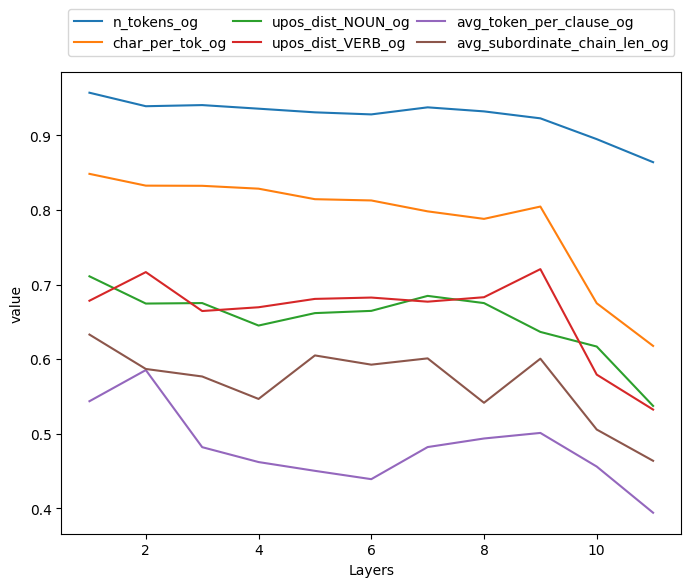

In [ ]:
# Formatting the dataframe in order to be visualized as a multiline plot
results = results[layers]
results = results.T
results["Layers"] = results.index
plot_results = pd.melt(results, ["Layers"])

# Visualization with seaborn
fig, ax = plt.subplots(figsize=(8, 6))
g = sns.lineplot(data=plot_results, x="Layers", y="value", hue="variable")
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 1.02, 1., .102),
              loc='lower left', ncol=3, mode="expand")

In [ ]:
model_name = "mpapucci/BertForItaCaseholdClassification"
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
model = model.to(device)

config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
embeddings = []
ids = []
sentences = []

# Extracting the representations from each sentence of the probing dataset, with model(*input_ids*), where *input_ids* corresponds to the tokenized sentence
for index, line in tqdm(df.iterrows(), total=len(df)):
  sent_id = index
  sentence = line['original_text']

  # Tokenization of the sentence
  input_ids = tokenizer.encode(sentence, add_special_tokens=True)
  input_ids = torch.tensor([input_ids]).to(device)

  # Extraction of the representations
  with torch.no_grad():
    outputs = model(input_ids)
    embeddings.append(outputs["hidden_states"])
    ids.append(sent_id)
    sentences.append(sentence)

100%|██████████| 2000/2000 [00:18<00:00, 108.82it/s]


In [ ]:
selected_features = ["n_tokens_og",
                     "char_per_tok_og",
                     "upos_dist_NOUN_og",
                     "upos_dist_VERB_og",
                     "avg_token_per_clause_og",
                     "avg_subordinate_chain_len_og"
                     ]
n_layers=12
layers = list(range(n_layers)[1:])

# Create an empty pandas DataFrame to store the probing results
results = pd.DataFrame(index=selected_features, columns=layers + ["Baseline"])

# Iterate over the selected features
with tqdm(total=len(selected_features) * len(layers), desc="Probing") as pbar:
  for feature in selected_features:
    # Iterate over the 12 layers of the model
    for layer in layers:
      pbar.update()
      corr, p_val = probing(embeddings, df, ids, feature, layer)

      # Save the score only if the correlation is statistically significant (p-value < 0.05)
      if p_val < 0.05:
        results.loc[feature, layer] = corr

# Simple baseline model trained to predict the selected linguistic feature using only "n_tokens" as input feature
  corr_baseline, p_val_baseline = baseline(df, feature)
  if p_val < 0.05:
    results.loc[feature, "Baseline"] = corr_baseline

Probing: 100%|██████████| 66/66 [00:44<00:00,  1.47it/s]


In [ ]:
results

,1,2,3,4,5,6,7,8,9,10,11,Baseline
n_tokens_og,0.957166,0.939881,0.941019,0.932346,0.927032,0.919666,0.933446,0.919802,0.893354,0.861925,0.843784,NaN
char_per_tok_og,0.849403,0.832349,0.831501,0.817449,0.804031,0.794775,0.768402,0.749729,0.729564,0.644525,0.503335,NaN
upos_dist_NOUN_og,0.708312,0.680416,0.67281,0.630253,0.655295,0.65413,0.663418,0.655711,0.546931,0.531381,0.511906,NaN
upos_dist_VERB_og,0.678483,0.717333,0.658715,0.662003,0.664597,0.654734,0.669666,0.6784,0.692525,0.585965,0.496925,NaN
avg_token_per_clause_og,0.539434,0.5796,0.478675,0.458127,0.450472,0.43436,0.464573,0.494241,0.448979,0.451003,0.364144,NaN
avg_subordinate_chain_len_og,0.63189,0.588688,0.57154,0.543912,0.571535,0.558638,0.571425,0.544651,0.532856,0.444452,0.437509,0.438317


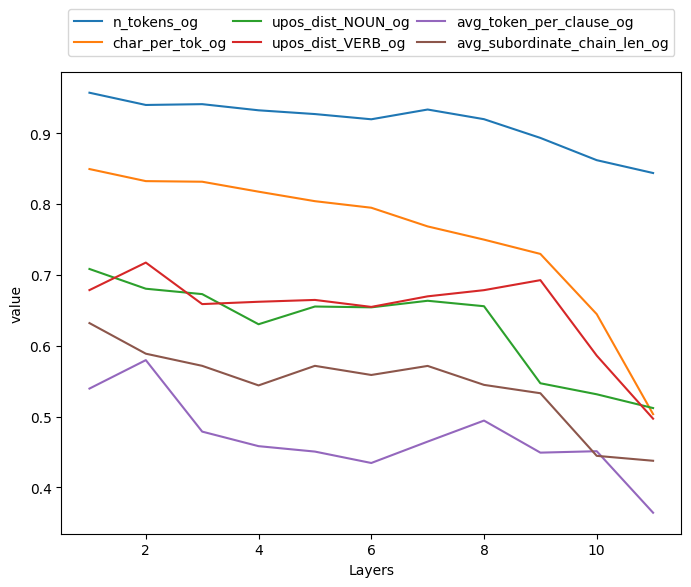

In [ ]:
# Formatting the dataframe in order to be visualized as a multiline plot
results = results[layers]
results = results.T
results["Layers"] = results.index
plot_results = pd.melt(results, ["Layers"])

# Visualization with seaborn
fig, ax = plt.subplots(figsize=(8, 6))
g = sns.lineplot(data=plot_results, x="Layers", y="value", hue="variable")
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 1.02, 1., .102),
              loc='lower left', ncol=3, mode="expand")